In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
import matplotlib.pyplot as plt
import torch
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product
from einops import rearrange

import models.models_original as models_original
import models.models_3d as models_3d
import models.models_3d_atomics as models_3d_atomics
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

device = get_free_gpu()


current device cuda:2


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_tiselac_dataloader(batch_size = 512, random_state = 1)

print(class_weights, num_classes)

for batch in train_loader:
    [print(t.shape) for t in batch]
    break

len(train_loader)

tensor([0.5538, 2.8525, 0.5538, 0.5710, 0.7132, 1.6248, 1.2057, 6.3149, 3.5524]) 9
torch.Size([512, 23, 10])
torch.Size([512, 23, 10])
torch.Size([512])


117

In [3]:
auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes).to(device)
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)
random_seeds = range(1,4)

experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/shared/"
top_k_file = experiment_folder + "top-k/bottleneck_topkinds_seed_{seed}.csv"

10 0 23


## Optim

In [4]:
def get_model(random_seed):
    set_seed(random_seed)

    config = {
        "n_concepts": 4,
        "encode_time_dim": True,
    }

    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config)
    model_path = model_path.format(**config, seed = random_seed)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_tiselac_dataloader(random_state = random_seed)

    model = models_3d.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=num_classes, device=device)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path, max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model(1)
get_model(2)
get_model(3)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.969
ACC macro 0.768
 F1 macro 0.721


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.969
ACC macro 0.767
 F1 macro 0.716


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.967
ACC macro 0.766
 F1 macro 0.712


CBM(
  (sigmoid_layer): Sigmoid()
  (output_af): Softmax(dim=1)
  (bottleneck): LazyLinearWithMask(in_features=0, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_output): Linear(in_features=0, out_features=9, bias=True)
)

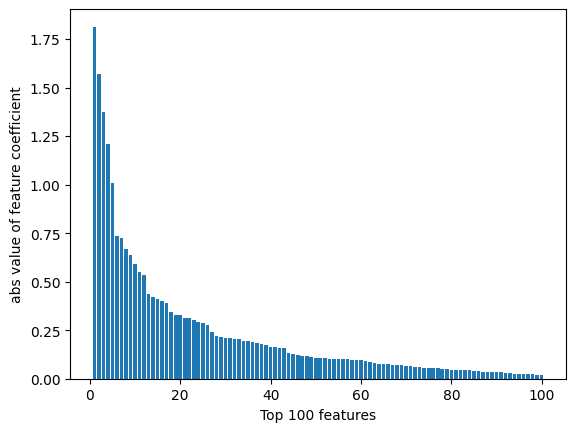

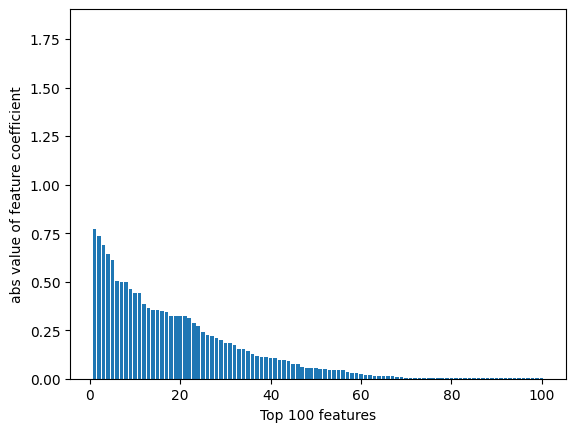

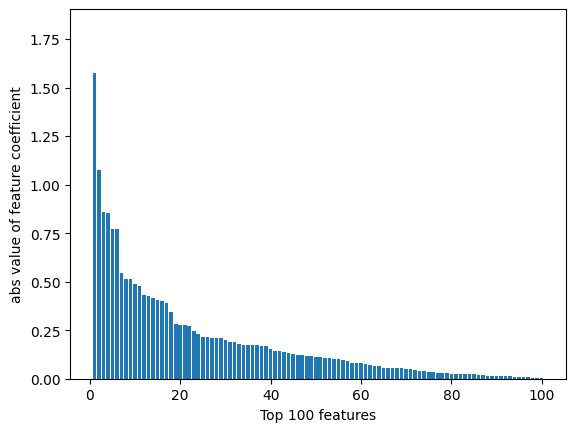

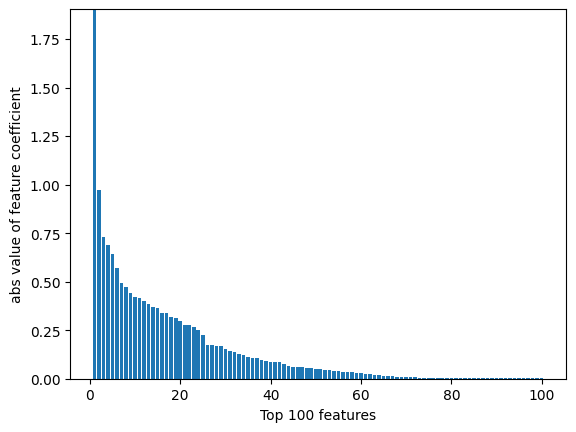

In [5]:
visualize_top100_weights_per_channel(model.bottleneck)


In [5]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

results = []
for random_seed in random_seeds:
    print("random_seed", random_seed)
    set_seed(random_seed)
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_tiselac_dataloader(random_state = random_seed)
    top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
    save_path = top_k_file.format(seed=random_seed)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, track_metrics=track_metrics, save_path=save_path)
    results.append(greedy_results)
    

random_seed 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.969
ACC macro 0.768
 F1 macro 0.721
Found 4 Concepts
90th percentile per concept [ 4.7204967  9.029183   2.8413498 10.475976 ]
['Concept 0 len: 10', 'Concept 1 len: 12', 'Concept 2 len: 10', 'Concept 3 len: 10']


100%|██████████| 40/40 [18:16<00:00, 27.41s/it, Score=0.96120, acc=0.757, f1=0.757, auc=0.961]


random_seed 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.969
ACC macro 0.767
 F1 macro 0.716
Found 4 Concepts
90th percentile per concept [ 6.101      5.1605434 12.367407   3.2225478]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10']


100%|██████████| 40/40 [16:32<00:00, 24.82s/it, Score=0.94120, acc=0.68, f1=0.68, auc=0.941]  


random_seed 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.967
ACC macro 0.766
 F1 macro 0.712
Found 4 Concepts
90th percentile per concept [ 4.3081007  4.46648    6.8198795 11.762087 ]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10']


100%|██████████| 40/40 [16:24<00:00, 24.62s/it, Score=0.94897, acc=0.715, f1=0.715, auc=0.949] 


In [ ]:
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/original/top-k/bottleneck_topkinds_1.csv")
pd.set_option('display.max_rows', 100)
greedy_results


In [ ]:
plot_selected_weights(model.bottleneck.weight, top_k_inds, greedy_results, 250)

In [6]:
result_df = evaluate_greedy_selection(get_model, get_tiselac_dataloader, top_k_file, n_experiments=3)
result_df.groupby(["Split", "Mask", "Finetuned"]).mean()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.969
ACC macro 0.768
 F1 macro 0.721
AUC macro 0.970
ACC macro 0.772
 F1 macro 0.726
AUC macro 0.969
ACC macro 0.768
 F1 macro 0.721
AUC macro 0.961
ACC macro 0.734
 F1 macro 0.687
AUC macro 0.960
ACC macro 0.734
 F1 macro 0.686
Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/finetuned/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.969
ACC macro 0.772
 F1 macro 0.717
AUC macro 0.967
ACC macro 0.769
 F1 macro 0.714


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.969
ACC macro 0.767
 F1 macro 0.716
AUC macro 0.967
ACC macro 0.762
 F1 macro 0.713
AUC macro 0.969
ACC macro 0.767
 F1 macro 0.716
AUC macro 0.941
ACC macro 0.664
 F1 macro 0.607
AUC macro 0.945
ACC macro 0.673
 F1 macro 0.615
Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/finetuned/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.969
ACC macro 0.766
 F1 macro 0.715
AUC macro 0.971
ACC macro 0.770
 F1 macro 0.719


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.967
ACC macro 0.766
 F1 macro 0.712
AUC macro 0.966
ACC macro 0.760
 F1 macro 0.710
AUC macro 0.967
ACC macro 0.766
 F1 macro 0.712
AUC macro 0.949
ACC macro 0.711
 F1 macro 0.645
AUC macro 0.951
ACC macro 0.723
 F1 macro 0.651
Loaded model from /workdir/optimal-summaries-public/_models/tiselac/shared/finetuned/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.968
ACC macro 0.762
 F1 macro 0.709
AUC macro 0.969
ACC macro 0.767
 F1 macro 0.712


Seed       AUC       ACC        F1
Split Mask   Finetuned                                    
test  Empty  False       2.0  0.968408  0.766927  0.716459
      Greedy False       2.0  0.951966  0.710131  0.650823
             True        2.0  0.968995  0.768563  0.714998
val   Empty  False       2.0  0.967666  0.764430  0.716357
      Greedy False       2.0  0.950458  0.703011  0.646448
             True        2.0  0.968446  0.766526  0.713719